# **Regressiya**
Deep Learning modellarini CV, NLP  kabi cheklangan turlarga klassifikatsiya qilingan deb o'ylashimiz mumkin. Haqiqatan ham, fastai o'zining ilovalarini asosan shunday tasniflaydi, chunki ko'pchilik ham shunday o'ylaydi.
Lekin, aslida, bu yanada qiziqarli va chuqurroq istiqbolni yashiradi. Model o'zining mustaqil va bog'liq o'zgaruvchilari va loss funktsiyasi bilan belgilanadi. Bu oddiy domenga asoslangan bo'linishdan ko'ra haqiqatan ham kengroq modellar qatori mavjudligini anglatadi. Ya'ni bizda rasmlar mustaqil o'zgaruvchi bo'lib matn bog'liq o'zgaruvchi bo'lishi mumkin(rasmga sarlavha topish),yoki mustaqil o'zgaruvchi sifatida rasm,matn va jasval bo'lishi mumkin ,bog'liq o'zgaruvchi esa bu yerda savdo haridlarini bashorat qilinishi bo'lishi mumkin.Bir so'z bilan aytsak bizda imkoniyatlar haqiqatcha cheksizdir.
Ruxsat etilgan ilovalardan tashqariga chiqib, yangi muammolarni hal qilish uchun o'zingizning yangi yechimlaringizni ishlab chiqish uchun API datablocki (va ehtimol API haqida ham ko'rib chiqarmiz) yaxshi tushunishga yordam beradi. Misol tariqasida tasvir regressiyasi muammosini ko'rib chiqamiz. Bu mustaqil o'zgaruvchi tasvir bo'lgan va bog'liq o'zgaruvchi bir yoki bir nechta float bo'lgan datasetdan o'rganishni anglatadi. Ko'pincha biz odamlar tasvir regressiyasini alohida dastur sifatida ko'rib chiqamiz, lekin bu yerda ko'rib turganingizdek, biz uni API databloki ustidagi boshqa CNN sifatida ko'rib chiqamiz.
Biz to'g'ridan-to'g'ri tasvir regressiyasining biroz murakkab variantiga o'tmoqchimiz, chunki siz bunga tayyor ekanligingizni bilamiz! Biz asosiy nuqta modelini yaratib ko'ramiz. Asosiy nuqta tasvirda ko'rsatilgan ma'lum bir joyga ishora qiladi. Biz bu yerda odam yuz  tasvirlaridan foydalanamiz va har bir rasmda odam yuzining markazini qidiramiz. Bu shuni anglatadiki, biz har bir rasm uchun ikkita qiymatni taxmin qilamiz,ular yuz markazining qator va ustuni.


#Datani yig'ish
Ushbu bo'lim uchun biz Biwi Kinect Head Pose datasetidan foydalanamiz. Biz odatdagidek datasetni yuklab olishdan boshlaymiz:

In [23]:
from fastai.vision.all import *

In [5]:
path = untar_data(URLs.BIWI_HEAD_POSE)

Qani endi datasetda o'zi nima borligini ko'rib chiqaylik:

In [6]:
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/15.obj'),Path('/root/.fastai/data/biwi_head_pose/02'),Path('/root/.fastai/data/biwi_head_pose/20.obj'),Path('/root/.fastai/data/biwi_head_pose/17.obj'),Path('/root/.fastai/data/biwi_head_pose/06'),Path('/root/.fastai/data/biwi_head_pose/13.obj'),Path('/root/.fastai/data/biwi_head_pose/21.obj'),Path('/root/.fastai/data/biwi_head_pose/07.obj'),Path('/root/.fastai/data/biwi_head_pose/09'),Path('/root/.fastai/data/biwi_head_pose/08.obj')...]

1 dan 24 gacha raqamlangan 24 ta fayl mavjud (suratga olingan turli odamlar) va har biri uchun mos keladigan .obj fayli (bu erda bizga kerak emas)dan iborat. Keling, ushbu kataloglardan birini ko'rib chiqaylik:

In [7]:
(path/'01').ls()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00284_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00270_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00264_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00416_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00395_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00011_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00472_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00442_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00262_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00491_pose.txt')...]

Ichki faylning ichida turli frame(ramka)lar mavjud.Har bir ramka rasm(rgb.jpg) va poza fayli(_pose.txt) dan  iborat.Biz get_image_files yordamida barcha tasvir fayllarini rekursiv ravishda osongina olishimiz mumkin, so'ngra rasm fayli nomini bog'langan poza fayliga o'zgartiruvchi funksiyani yozishimiz mumkin:

In [8]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/02/frame_00270_pose.txt')

Qani endi birinchi rasmga qarab ko'raylik:

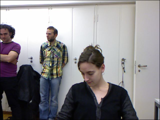

In [10]:
im = PILImage.create(img_files[0])
im.shape
(480, 640)
im.to_thumb(160)

Aslida Biwi dataseti veb-sayti bosh markazining joylashishini ko'rsatadigan har bir tasvir bilan bog'liq poza matn fayli formatini tushuntirish uchun ishlab chiqilgan.Lekin buning tafsilotlari bizning maqsadlarimiz uchun muhim emas.Biz shunchaki bosh markaz nuqtasini chiqarish uchun foydalanadigan funktsiyani ko'rsatamiz.

In [11]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
 ctr = np.genfromtxt(img2pose(f), skip_header=3)
 c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
 c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
 return tensor([c1,c2])

Bu funksiya koordinatalarni ikkita elementning tensori sifatida qaytaradi:

In [12]:
get_ctr(img_files[0])

tensor([384.6370, 259.4787])

tensor([384.6370, 259.4787])

Ushbu funktsiyani DataBlock-ga get_y sifatida o'tkazishimiz mumkin, chunki u har bir elementni labellab beryapdi. Training vaqtini biroz tezlashtirish uchun biz tasvirlarning o'lchamini kiritilgan o'lchamining yarmiga o'zgartiramiz.
Shuni ta'kidlash kerakki, biz shunchaki tasodifiy ajratgich(random splitter)dan foydalanmasligimiz kerak. Ushbu datasetda bir xil odamlar bir nechta tasvirlarda paydo bo'ladi, ammo biz modelimiz hali ko'rmagan odamlarga umumlashtirilishiga ishonch hosil qilishni xohlaymiz.Datasetgi har bir papkada bir kishi uchun tasvirlar mavjud. Shunda biz faqat bir kishi uchun True qiymatini qaytaradigan splitter funksiyasini yaratishimiz mumkin, natijada faqat shu shaxsning rasmlarini o'z ichiga olgan validation set paydo bo'ladi.

In [14]:
biwi = DataBlock(
 blocks=(ImageBlock, PointBlock),
 get_items=get_image_files,
 get_y=get_ctr,
 splitter=FuncSplitter(lambda o: o.parent.name=='13'),
 batch_tfms=[*aug_transforms(size=(240,320)),
 Normalize.from_stats(*imagenet_stats)])

**Data augmentation**

Biz koordinatalarda ma'lumotlarni ko'paytirishni avtomatik va to'g'ri qo'llaydigan boshqa kutubxonalarni (fastai-dan tashqari) bilmaymiz. Shuning uchun agar siz boshqa kutubxona bilan ishlayotgan bo'lsangiz, bunday muammolar uchun ma'lumotlarni ko'paytirishni o'chirib qo'yishingiz kerak bo'lishi mumkin

Har qanday modellashtirishni amalga oshirishdan oldin, biz ma'lumotlarimizning yaxshi ko'rinishini bir ko'rib tekshirib olishimiz kerak:

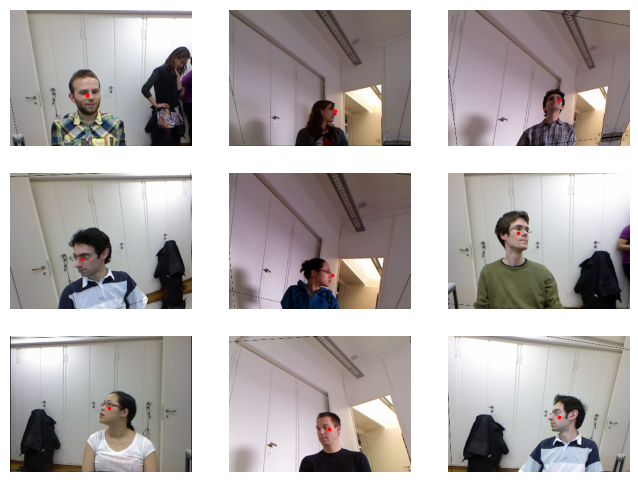

In [15]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

Yaxshigina ko'rinyapdi! To'plamni vizual ko'rib chiqish bilan bir qatorda, asosiy tensorlarni ham ko'rib chiqish yaxshi fikrdir (ayniqsa, talaba sifatida; bu sizning modelingiz haqiqatda nimani ko'rayotganini tushunishingizga yordam beradi):

In [16]:
xb,yb = dls.one_batch()
xb.shape,yb.shape



(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

Bizning mini-batchlarimiz uchun bu shakllar nima uchun ekanligini tushunganingizga ishonch hosil qiling.
Bog'liq o'zgaruvchidan bitta misolni ko'raylik:

In [18]:
yb[0]

TensorPoint([[ 0.3014, -0.1303]])

Ko'rib turganingizdek, biz alohida rasm regressiya dasturidan foydalanishimiz shart emas edi. Biz qilishimiz kerak bo'lgan yagona narsa ma'lumotlarni belgilash va mustaqil va bog'liq o'zgaruvchilar qanday ma'lumotlar turlarini ifodalashini fastai-ga aytib berishdir.
Learnerni yaratish  ham xuddi shu yo'sinda qilinadi. Biz oldingi kabi funksiyadan bitta yangi parametr bilan foydalanamiz va modelimizni train qilish uchun tayyor bo'lamiz.

# **Modelni train qilish**



Odatdagidek, biz cnn_learner dan foydalanib learnerni yaratamiz.1-bobda qanday qilib biz y_rangedan Fastaiga maqsadlarimiz oralig'ini aytib berganimiz esingizdami? Biz bu yerda ham xuddi shunday qilamiz (fastai va PyTorch koordinatalari har doim -1 va +1 oralig'ida o'zgartiriladi):

In [36]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")



y_range fastai'da signmoid_range yordamida amalga oshiriladi, bu quyidagicha aniqlanadi:

In [37]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

Agar y_range aniqlangan bo'lsa, bu modelning oxirgi qatlami sifatida o'rnatiladi. Bu funksiya nima qilishini va nima uchun u modelni diapazondagi faollashtirishlarni chiqarishga majbur qilishini o'ylab ko'ring (lo, hi).
Bu qanday ko'rinishga ega:

In [39]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

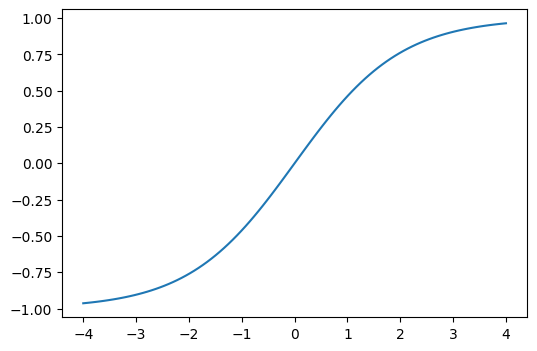

In [41]:
def plot_function(f, tx=None, ty=None, title=None, min_val=-2, max_val=2, figsize=(6,4)):
    x = torch.linspace(float(min_val), float(max_val), 100)
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(x, f(x))
    if tx is not None:
        ax.set_xlabel(tx)
    if ty is not None:
        ax.set_ylabel(ty)
    if title is not None:
        ax.set_title(title)

plot_function(partial(sigmoid_range, lo=-1, hi=1), min_val=-4, max_val=4)


Biz loss funksiyasini belgilamadik, ya'ni biz fastai avtomatik tanlaganini qabul qilamiz. Keling, u biz uchun nimani tanlaganini ko'rib chiqaylik:

In [42]:
dls.loss_func

FlattenedLoss of MSELoss()

Bu mantiqan to'g'ri keladi, chunki koordinatalar bog'liq o'zgaruvchi sifatida ishlatilganda, biz ko'pincha imkon qadar yaqinroq narsani bashorat qilishga harakat qilamiz;.Bu, asosan, MSELoss (kvadrat xatolik yo'qotilishi) bajaradigan narsadir. Agar siz boshqa loss funksiyasidan foydalanmoqchi bo'lsangiz, loss_func parametridan foydalanib, uni cnn_learner-ga o'tkazishingiz mumkin.
Shuni ham yodda tutingki, biz hech qanday ko'rsatkichni belgilamadik. Buning sababi, MSE allaqachon bu vazifa uchun foydali ko'rsatkichdir (garchi biz kvadrat ildizni olganimizdan so'ng buni yanada izohlash mumkin bo'lsa ham).
Biz training tezligini topuvchi yordamida yaxshi o'rganish tezligini tanlashimiz mumkin:

In [ ]:
learn.lr_find()

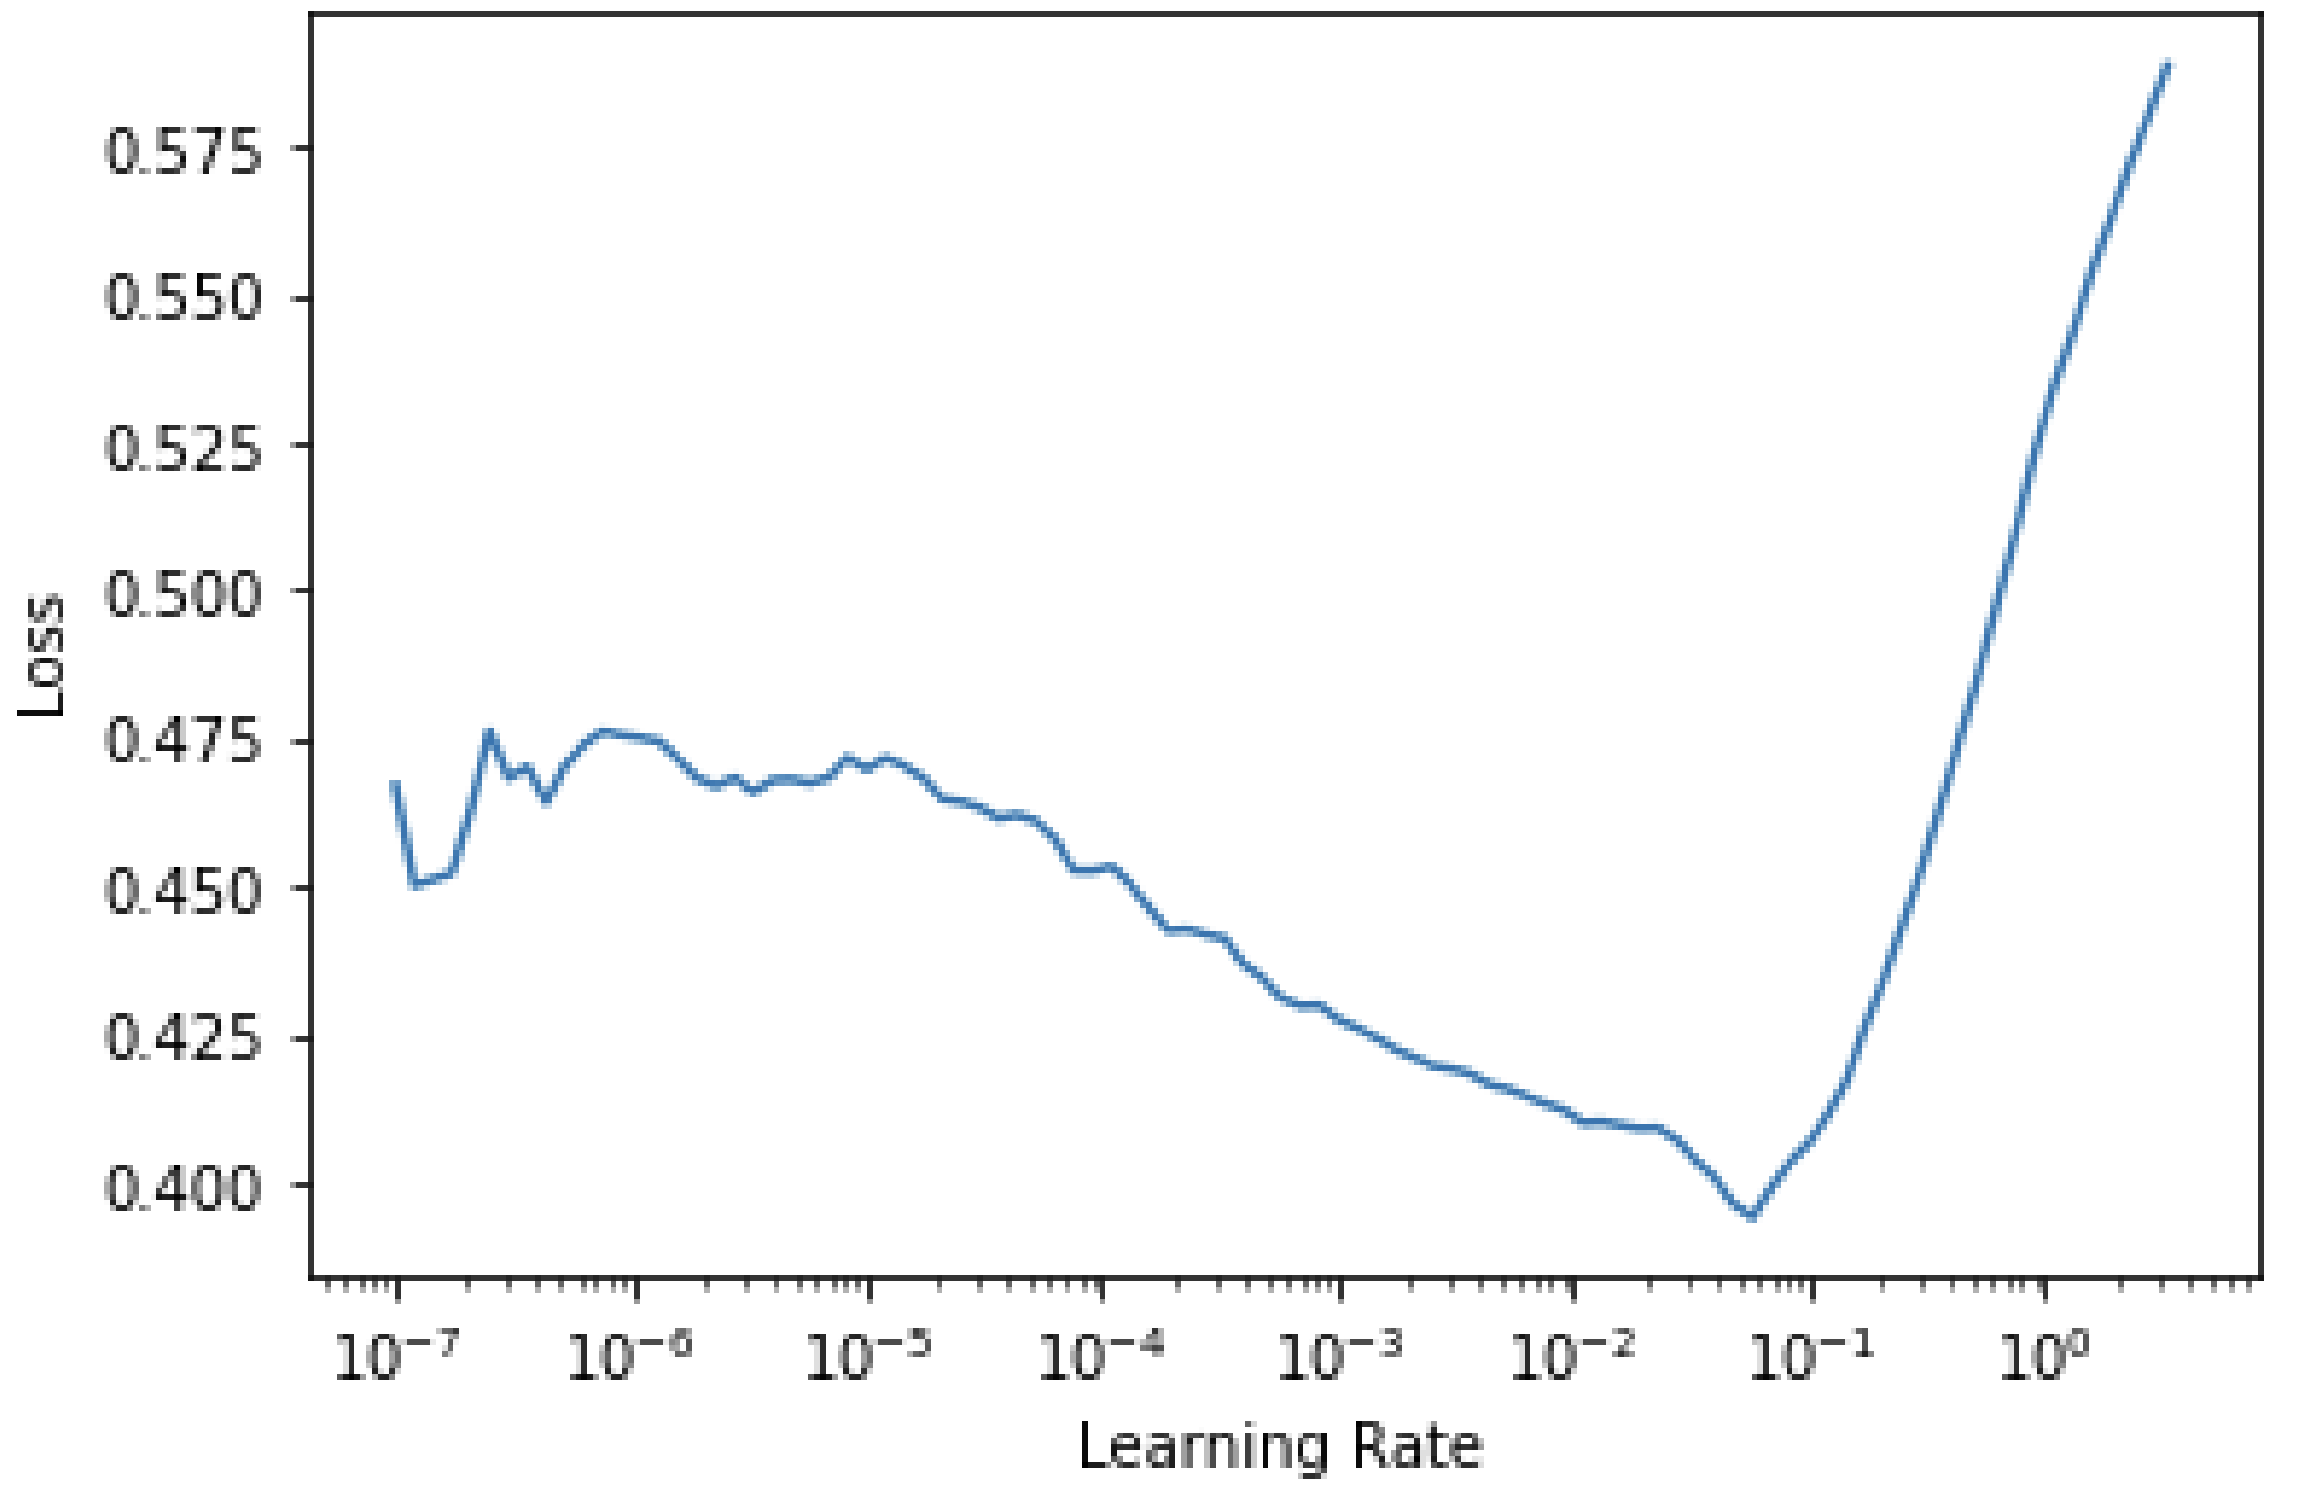![image.png](![image.png]())

Endi esa LR 2e-2 ni sinab ko'ramiz:

In [ ]:
lr = 2e-2
learn.fit_one_cycle(5, lr)

Umuman olganda, biz buni ishga tushirganimizda, biz taxminan 0,0001 yo'qotamiz, bu o'rtacha koordinatani bashorat qilish xatosiga to'g'ri keladi:

In [1]:
math.sqrt(0.0001)

NameError: name 'math' is not defined

Bu juda aniq degani! Lekin Learner.show_results bilan albatta natijalarimizni ko'rib chiqish kerak. Chap tomonda haqiqiy (asosiy haqiqat) koordinatalari, o'ng tomonda esa modelimiz bashoratlari mavjud:

In [ ]:
learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))

Ajablanarlisi shundaki, atigi bir necha daqiqalik hisob-kitoblar natijasida biz domenga oid maxsus dastursiz shunday aniq asosiy nuqtalar modelini yaratdik. Bu moslashuvchan API- larni qurish va transferni o'rganishdan foydalanish kuchidir! Biz transfer o'rganishdan, hatto butunlay boshqa vazifalar orasida ham samarali foydalana olganimiz ayniqsa quvonarli.Bizdagi pretrained modelimiz tasvirni tasniflash uchun o'rgatilgan va biz tasvir regressiyasini yaxshi sozladik.

